## Data Overview

Check the competition page: https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/

## Dependencies

In [1]:
# Downgrade tf to prevent errors in mrcnn
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 66kB/s 
     |████████████████████████████████| 3.2MB 25.0MB/s 
     |████████████████████████████████| 491kB 30.9MB/s 
  Found existing installation: tensorboard 2.0.0
    Uninstalling tensorboard-2.0.0:
      Successfully uninstalled tensorboard-2.0.0
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [2]:
# Downgrade keras to prevent errors in mrcnn
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
import numpy as np
import pandas as pd

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import gc
import json
import glob
from pathlib import Path
import keras # to prevent error when importing mrcnn.model
import tensorflow as tf

import itertools
from tqdm import tqdm

from sklearn.model_selection import train_test_split

tf.__version__
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [4]:
# Root and data directory of the project
ROOT_DIR = Path('/kaggle/working')

# Download Mask RCNN library
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 44.59 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [5]:
# Import Mask RCNN
sys.path.append(ROOT_DIR/'Mask_RCNN')  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
import mrcnn.model as modellib

In [6]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


## Configurations

In [7]:
# Define config class
class MyConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = 46 + 1 # background + 46 classes
    
    EPOCHS = 1
    TRAIN_SIZE = 1/1000
    VAL_SIZE = 1/10000
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = 5
    VALIDATION_STEPS = 1
    
    LEARNING_RATE = 0.002

# Create instance for late use in the model
config = MyConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE             

## Dataset

In [8]:
# Load label json
train_dir = '/kaggle/input/imaterialist-fashion-2019-FGVC6/'
# Get class names
with open(train_dir+'label_descriptions.json') as f:
    label_descriptions = json.load(f)
label_names = [x['name'] for x in label_descriptions['categories']]

In [9]:
# Load train table
df = pd.read_csv(train_dir+'train.csv')
# Remove attributs from catagory
df['labels'] = df['ClassId'].apply(lambda x: x.split('_')[0])

In [10]:
# Group by image id and concatenate EncodedPixels and labels
g1_df = df.groupby('ImageId')['EncodedPixels','labels'].agg(lambda x: list(x))
g2_df = df.groupby('ImageId')['Height', 'Width'].mean()

train_df = g1_df.join(g2_df, on='ImageId')

In [11]:
# Train and validation split
df_train,df_val = train_test_split(train_df,train_size=config.TRAIN_SIZE ,test_size=config.VAL_SIZE)

In [12]:
# Extend the Dataset class and add load_data() to load the training data. 
# Override the following methods:
#  load_image()
#  load_mask()
#  image_reference()

class MyDataset(utils.Dataset):

    def load_data(self, label_names, df):
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            
            self.add_image("fashion", 
                           image_id=i, 
                           path=train_dir+'train/'+i, 
                           labels=row['labels'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], 
                           width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):       
        img = cv2.imread(self.image_info[image_id]['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM), interpolation=cv2.INTER_AREA)  
        return img

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/43f221985dfd5131a3eabbebf79655f3.jpg', ['headband, head covering, hair accessory', 'dress', 'neckline', 'flower', 'shoe', 'shoe', 'applique'])


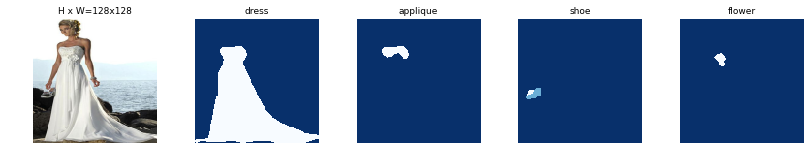

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/c10940b2a58cb0869fdc72c6990e652e.jpg', ['top, t-shirt, sweatshirt', 'neckline'])


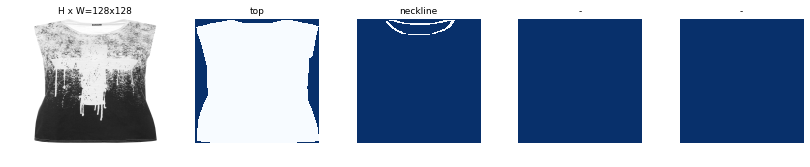

In [13]:
# Create dataset for later use in the model
train_dataset = MyDataset()
train_dataset.load_data(label_names,df_train)
train_dataset.prepare()

valid_dataset = MyDataset()
valid_dataset.load_data(label_names,df_val)
valid_dataset.prepare()

# Visualize samples
for i in range(2):
    image_id = random.choice(train_dataset.image_ids)
    print(train_dataset.image_reference(image_id))
    
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=4)

## Build Model

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=ROOT_DIR)

# Load weights trained on MS COCO, but skip layers that are different due to the different number of classes
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [15]:
# Train the heads
model.train(train_dataset, valid_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=config.EPOCHS, 
            layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: /kaggle/working/fashion20191206T1751/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/1
5/5 [==============================] - 895s 179s/step - loss: 6.8949 - rpn_class_loss: 0.5488 - rpn_bbox_loss: 1.7656 - mrcnn_class_loss: 2.5602 - mrcnn_bbox_loss: 1.1724 - mrcnn_mask_loss: 0.8479 - val_loss: 5.0988 - val_rpn_class_loss: 0.3078 - val_rpn_bbox_loss: 2.0478 - val_mrcnn_class_loss: 0.7416 - val_mrcnn_bbox_loss: 1.1815 - val_mrcnn_mask_loss: 0.8201


In [16]:
# Fine tune all layers
model.train(train_dataset, valid_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=config.EPOCHS, 
            layers='all')
new_history = model.keras_model.history.history
for k in new_history: 
    history[k] = history[k] + new_history[k]


Starting at epoch 1. LR=0.002

Checkpoint Path: /kaggle/working/fashion20191206T1751/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

## Detect Objects

In [17]:
# Create a configuration for inference
class InferenceConfig(MyConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/fashion20191206T1751/mask_rcnn_fashion_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
image_meta               shape: (59,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (3,)                  min:   11.00000  max:   38.00000  int64
gt_bbox                  shape: (3, 4)                min:   31.00000  max:  122.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  uint8


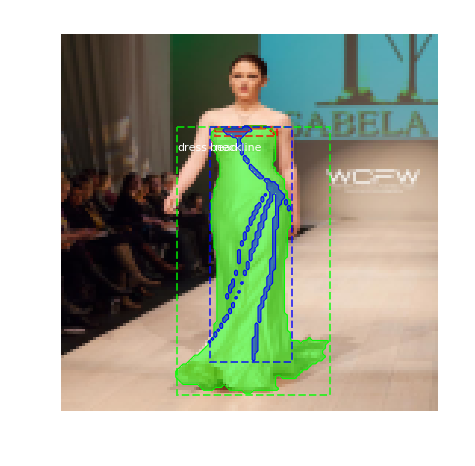

In [18]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)

# Get original image data
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Visualize original image
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_dataset.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -122.70000  max:  135.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -1.42535  max:    1.92141  float32

*** No instances to display *** 



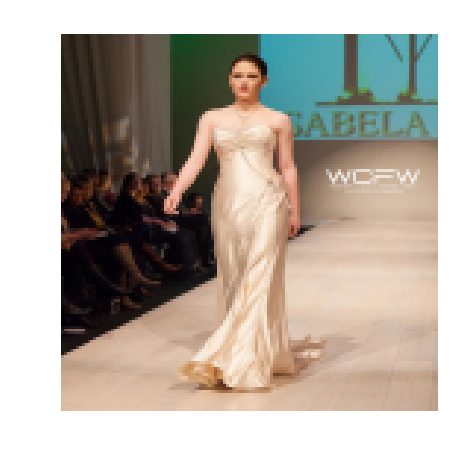

In [19]:
# Predict and visualize on the same image
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            valid_dataset.class_names, r['scores'],figsize=(8, 8))

## Evaluation

In [20]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(valid_dataset.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(valid_dataset, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
